In [1]:
import pandas as pd
import chromadb
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

tab = pd.read_csv("pkm.csv")
tab

,Numero,Nom,Type,Description
0,1,Bulbizarre,Pokémon Graine,"Au matin de sa vie, la graine sur\nson dos lui..."
1,2,Herbizarre,Pokémon Graine,"Lorsque le bourgeon sur son dos\néclot, il rép..."
2,3,Florizarre,Pokémon Graine,Le parfum de sa fleur se fait plus\npénétrant ...
3,4,Salamèche,Pokémon Lézard,La flamme de sa queue symbolise sa\nvitalité. ...
4,5,Reptincel,Pokémon Flamme,"La nuit, la queue ardente du Reptincel\nbrille..."
...,...,...,...,...
146,147,Minidraco,Pokémon Dragon,On l’appelle “Pokémon mirage”\nen raison de sa...
147,148,Draco,Pokémon Dragon,La météo change brusquement quand\nil est ento...
148,149,Dracolosse,Pokémon Dragon,On raconte qu’il vit quelque part\nen mer. Il ...
149,150,Mewtwo,Pokémon Génétique,Un Pokémon conçu en réorganisant\nles gènes de...


In [2]:
client = chromadb.HttpClient(host = "chroma", port = 8000)
print(client.list_collections())

#client.delete_collection("pokemon")
#print(client.list_collections())

[]


In [3]:
client = chromadb.HttpClient(host = "chroma", port = 8000)
collection = client.get_or_create_collection(name = "pokemon")

for i in range(len(tab)):
    response = requests.post(
        "http://ollama:11434/api" + "/embeddings",
        json = {
            "model": "snowflake-arctic-embed2:568m-l-fp16",
            "prompt": tab["Description"][i],
        }
    )
    json = {
        "Numero": str(tab["Numero"][i]),
        "Nom": str(tab["Nom"][i]),
        "Type": str(tab["Type"][i]),
        "Description": str(tab["Description"][i]),
    }
    vector = response.json()["embedding"]
    collection.add(
        ids = str(tab["Numero"][i]),
        embeddings = [vector],
        metadatas = json
    )

In [4]:
query_prompt = "C'est une créature qui dort vraiment beaucoup"
response = requests.post(
    "http://ollama:11434/api/embeddings",
    json={"model": "snowflake-arctic-embed2:568m-l-fp16", "prompt": query_prompt}
)

query_vector = response.json()["embedding"]
collection = client.get_collection(name="pokemon")
results = collection.query(
    query_embeddings=[query_vector],
    n_results=5,
)

print("Closest IDs (Pokémon names):", results["ids"])
print("Similarities:", results["distances"])
print("Metadata (Descriptions, etc.):", results["metadatas"])

Closest IDs (Pokémon names): [['63', '96', '48', '54', '93']]
Similarities: [[119.08477783203125, 133.79103088378906, 136.52243041992188, 137.8493194580078, 138.87753295898438]]
Metadata (Descriptions, etc.): [[{'Description': 'L’utilisation de ses pouvoirs\nmentaux le fatigue tellement\nqu’il dort 18 heures par jour.', 'Nom': 'Abra', 'Numero': '63', 'Type': 'Pokémon Psy'}, {'Description': 'Son grand nez lui permet de lire\nles rêves d’autrui. Il adore les\nsonges amusants.', 'Nom': 'Soporifik', 'Numero': '96', 'Type': 'Pokémon Hypnose'}, {'Description': 'Ses grands yeux sont en fait des\namas d’yeux minuscules. La nuit,\nil est attiré par la lumière.', 'Nom': 'Mimitoss', 'Numero': '48', 'Type': 'Pokémon Vermine'}, {'Description': 'Ses pouvoirs déconcertants\net mystérieux lui font subir\nde constantes migraines.', 'Nom': 'Psykokwak', 'Numero': '54', 'Type': 'Pokémon Canard'}, {'Description': 'Il adore se tapir dans l’ombre et\nfaire frissonner ses proies en leur\ntouchant l’épaule.', 

In [5]:
collection = client.get_collection(name="pokemon")
results = collection.get(include=["embeddings", "metadatas"])
embeddings = np.array(results["embeddings"])
ids = [results["metadatas"][i]["Nom"] for i in range(len(results["ids"]))]
cosine_matrix = cosine_similarity(embeddings)
print(cosine_matrix)

[[1.         0.49671715 0.34238282 ... 0.42831061 0.19059573 0.29116585]
 [0.49671715 1.         0.52152242 ... 0.33148999 0.21153497 0.21645763]
 [0.34238282 0.52152242 1.         ... 0.3384655  0.42686064 0.47574236]
 ...
 [0.42831061 0.33148999 0.3384655  ... 1.         0.24666473 0.31722213]
 [0.19059573 0.21153497 0.42686064 ... 0.24666473 1.         0.57085699]
 [0.29116585 0.21645763 0.47574236 ... 0.31722213 0.57085699 1.        ]]


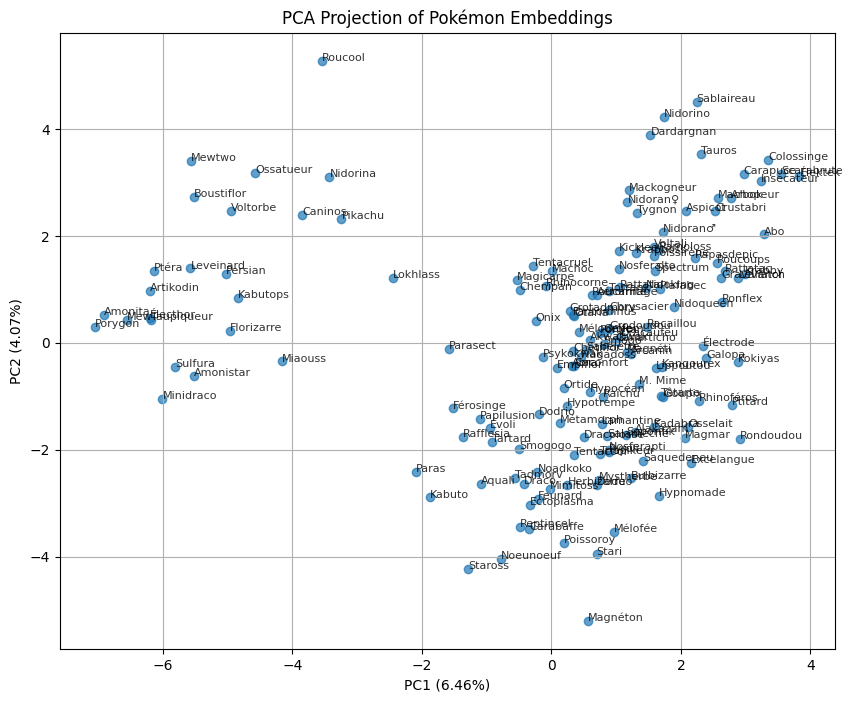

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to %
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
for i, name in enumerate(ids):
    plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.8)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Projection of Pokémon Embeddings")
plt.grid(True)
plt.show()